<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>

<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

The following code is used to crudely classify wells defined by their proximity to centriods defined by each demand location

Import Libraries

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Load and explore data

In [2]:
data = pd.read_csv('Surface locations.csv')
data.head()

,Label,Type,x,y
0,E01,Exploration,195,70
1,E02,Exploration,145,41
2,E03,Exploration,46,46
3,E04,Exploration,52,100
4,E05,Exploration,72,152


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   14 non-null     object
 1   Type    14 non-null     object
 2   x       14 non-null     int64 
 3   y       14 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 576.0+ bytes


In [4]:
data['Type'] = data['Type'].astype("category")

In [5]:
data['Type'].unique()

['Exploration', 'Injector', 'Producer', 'Demand']
Categories (4, object): ['Demand', 'Exploration', 'Injector', 'Producer']

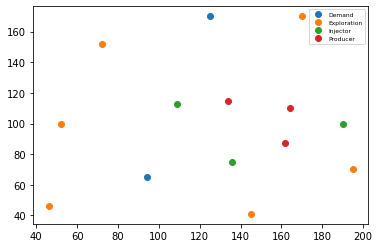

In [6]:
%matplotlib inline
groups = data.groupby('Type')
for name, group in groups:
    plt.plot(group['x'], group['y'], marker = "o", linestyle = "", label = name)
plt.legend(prop={'size':6})

Define demand locations as centroids

In [7]:
data.query('Type=="Demand"').head()

,Label,Type,x,y
12,D1,Demand,94,65
13,D2,Demand,125,170


In [8]:
#remove unneeded columns
df = data.drop(data.columns[[0,1]], axis=1)
centroids = df[12:14] #let data points 12 and 13 be centroids
print(centroids)

      x    y
12   94   65
13  125  170


In [9]:
kmeans = KMeans(n_clusters=2, init = centroids, max_iter=1) #just run one k-Means iteration so that the centroids are not updated
kmeans.fit(df)
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [10]:
#what is the squared distance to demand location?
df_dist = kmeans.transform(df)**2
df_dist = pd.DataFrame(df_dist.sum(axis=1).round(2), columns=['sqdist'])
df_dist

,sqdist
0,13181.31
1,10956.73
2,23356.06
3,14416.06
4,13266.73
5,13766.73
6,9482.56
7,4130.64
8,3201.73
9,4572.23


Create an output copy of data

In [11]:
#Add a column with cluster assignment labels
output = data.copy()
output.insert(4,'Cluster', labels)
output.insert(5,'sqdist', df_dist)
output = output.sort_values(["Cluster", "sqdist"], ascending = (False, True))
print(output)

   Label         Type    x    y  Cluster  sqdist
4    E05  Exploration   72  152        1  sqdist
5    E06  Exploration  170  170        1  sqdist
6    I01     Injector  190  100        1  sqdist
9    P01     Producer  164  110        1  sqdist
11   P03     Producer  134  115        1  sqdist
13    D2       Demand  125  170        1  sqdist
0    E01  Exploration  195   70        0  sqdist
1    E02  Exploration  145   41        0  sqdist
2    E03  Exploration   46   46        0  sqdist
3    E04  Exploration   52  100        0  sqdist
7    I02     Injector  136   75        0  sqdist
8    I03     Injector  109  113        0  sqdist
10   P02     Producer  162   87        0  sqdist
12    D1       Demand   94   65        0  sqdist


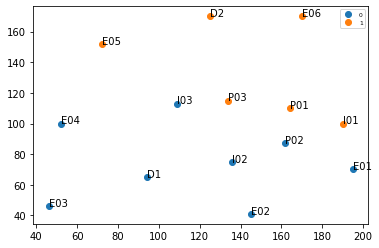

In [12]:
%matplotlib inline
groups = output.groupby('Cluster')
for name, group in groups:
    plt.plot(group['x'], group['y'], marker = "o", linestyle = "", label = name)
plt.legend(prop={'size':6})

for idx, row in output.iterrows():
    plt.annotate(row['Label'], (row['x'], row['y']))